# Traveling Salesman Problem
### Universität der Bundeswehr München - Prof. Dr. Claudius Steinhardt - Logistics Analytics

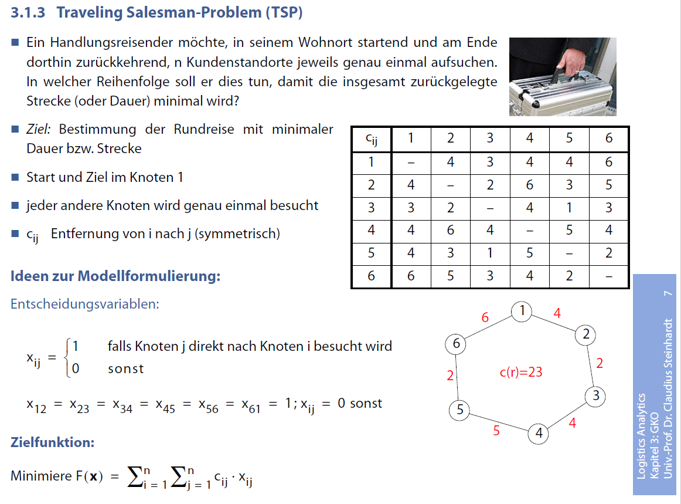

In [1]:
#Importieren der benötigten Bibliotheken
import itertools

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp
from pulp import *

import warnings
warnings.filterwarnings("ignore")



In [2]:
# Definieren TSP

#Anzahl Kunden
kunden = 8 

#Anzahl Kundenstandorte (Kunden + Start)
k = kunden  + 1

# Erstellen eines zufälligen Dataframes mit Koordinaten

df = pd.DataFrame({
    'x': np.random.randint(0, 100, k),
    'y': np.random.randint(0, 100, k),
})

# Definieren der linken unteren Ecken des Koordinatensystems


df.iloc[0]['x'] = 0
df.iloc[0]['y'] = 0

# Output Dataframe
df

,x,y
0,0,0
1,87,81
2,35,21
3,18,8
4,71,63
5,37,96
6,96,30
7,55,28
8,94,83


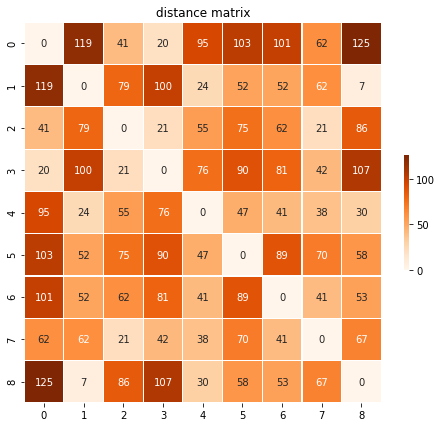

In [3]:
#  Erstellen Entfernungsmatrix aus Koordinaten
entfernungen = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

# Anzeigen Entfernungsmaxtrix 
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(entfernungen, ax=ax, cmap='Oranges', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()

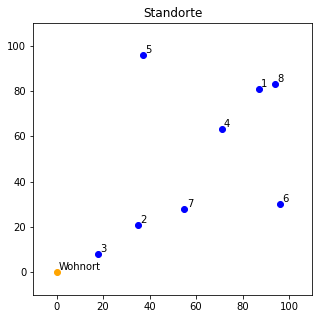

In [4]:
# Darstellung TSP graphisch

plt.figure(figsize=(5, 5))

# Problem darstellen
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='orange')
        plt.text(row['x'] + 1, row['y'] + 1, 'Wohnort')
    else:
        plt.scatter(row['x'], row['y'], c='blue')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('Standorte')
plt.show()

In [5]:
# Erstellen eines neuen PulP-Modells und festlegen ob es ein Maximierungs- oder Minimierungsproblem sein soll.
prob = LpProblem("TSP", LpMinimize)

In [6]:
# Erstellen der Variablen
## PulP Variablen bestehen aus vier Parametern: Name, Untere Grenze, Obere Grenze und diskret, linear oder binär
### Ist kein Wert für ein Parameter angegeben, so nimmt PulP Standartwerte vor.
#### Bei binären Variablen ist die untere und obere Grenze dementsprechen 0 und 1 zu setzen.
x = LpVariable.dicts('x', ((i, j) for i in range(k) for j in range(k)), lowBound=0, upBound=1, cat='Binary')

# Erstellen einer Entscheidungsvariablen um Kurzzyklen zu vermeiden mit der unteren Grenze 1 und der oberen Grenze k
u = LpVariable.dicts('u', (i for i in range(k)), lowBound=1, upBound=k, cat='Integer')

In [7]:
# Festlegen der Zielfunktion
prob += lpSum(entfernungen[i][j] * x[i, j] for i in range(k) for j in range(k))

In [8]:
# Unter der Nebenbedingung 1:
for i in range(k):
    prob += x[i, i] == 0

for i in range(k):
    prob += lpSum(x[i, j] for j in range(k)) == 1
    prob += lpSum(x[j, i] for j in range(k)) == 1

In [9]:
# Unter der Nebenbedingung 2: Vermeiden von Kurzzyklen
for i in range(k):
    for j in range(k):
        if i != j and (i != 0 and j != 0):
            prob += u[i] - u[j] <= k * (1 - x[i, j]) - 1

In [10]:
# Modell lösen
prob.solve()

1

In [11]:
# Augeben des Status
print("Status:", LpStatus[prob.status])

Status: Optimal


In [12]:
# Ausgeben der Knoten und deren Reihenfolge
#for v in prob.variables():
#    print(v.name, "=", v.varValue)
        
# Ausgeben Mindestentfernung
print("Mindestentfernung: ", value(prob.objective))

Mindestentfernung:  337.4478970121941


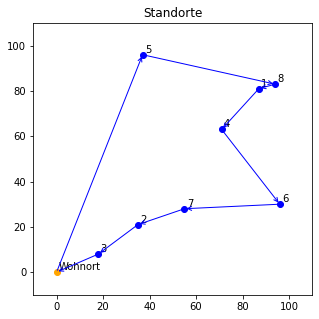

In [13]:
# Darstellung TSP graphisch

plt.figure(figsize=(5, 5))

# Problem darstellen
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='orange')
        plt.text(row['x'] + 1, row['y'] + 1, 'Wohnort')
        
    else:
        plt.scatter(row['x'], row['y'], c='blue')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('Standorte')

# Optimale Route zeichnen
routes = [(i, j) for i in range(k) for j in range(k) if pulp.value(x[i, j]) == 1]
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in routes:
    plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)

# Lösung anzeigen
plt.show()